In [27]:
import numpy as np
import pandas as pd
import pandas.io.sql as psql
from pandas import ExcelWriter
from pandas import ExcelFile

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
plt.style.use("ggplot")
plt.tight_layout()
import seaborn as sns



<Figure size 432x288 with 0 Axes>

In [28]:
comparision_df = pd.read_csv('../data/clean_sales_data.csv')
comparision_df

,Property Name,Property Code,Brand,#Rooms,Activation Date,Revenue,Profit Margin,Gross Profit,Flag,Size Subset,SPOR,Group,Type
0,Hilton Garden Inn Times Square,NYCMW,Hilto,369.0,2017-10-27,48190.59,0.72970,35164.64,Hilton Garden Inn,5,6.272227,Select Service,Focused Service
1,InterContinental New Orleans,MSYHA,IHG,484.0,2018-09-20,22829.80,0.67301,15364.72,InterContinental,5,2.265388,Full Service,Full Service
2,DoubleTree Suites by Hilton Hotel Boston - Cam...,BOSSB,Hilto,308.0,2018-06-11,22488.70,0.69884,15715.96,DoubleTree by Hilton,5,3.506707,Full Service,Full Service
3,Crowne Plaza Lansing West,LANCP,IHG,212.0,2018-10-26,611.00,0.60129,367.39,Crowne Plaza,5,0.138418,Full service,Full service
4,Homewood Suites Savannah Historic District,SAVRB,Hilto,162.0,2018-04-10,14439.60,0.63231,9130.27,Homewood Suites by Hilton,4,4.280811,All Suites,All Suites
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2545,Hampton Inn Magnolia,AGOSN,Hilto,68.0,2018-04-03,835.85,0.60038,501.83,Hampton Inn by Hilton,1,0.590344,Select Service,Focused Service
2546,Tru by Hilton Bryan College Station,CLLCS,Hilto,98.0,2018-08-27,809.84,0.67184,544.08,Tru by Hilton,2,0.396880,Select Service,Focused Service
2547,Comfort Suites Downtown Orlando,FL094,Choic,122.0,2017-07-13,762.75,0.58116,443.28,Comfort Suites,3,0.300267,Other,Other
2548,Hampton Inn Greensboro-East,GSOEA,Hilto,78.0,2018-09-29,614.38,0.54211,333.06,Hampton Inn by Hilton,1,0.378293,Select Service,Focused Service


Property Name Property Code Brand  #Rooms  \
3                      Crowne Plaza Lansing West         LANCP   IHG   212.0   
15                        Crowne Plaza Baltimore     IHG-BALWB   IHG   385.0   
78                        Crowne Plaza Baltimore     IHG-BALWB   IHG   385.0   
138                       Crowne Plaza Baltimore     IHG-BALWB   IHG   385.0   
208   Crowne Plaza Greenville-I-385-Roper Mtn Rd         GSPRM   IHG   202.0   
...                                          ...           ...   ...     ...   
2419                Crowne Plaza Downtown Denver     IHG-DENDT   IHG   380.0   
2422                Crowne Plaza Downtown Denver     IHG-DENDT   IHG   380.0   
2447                Crowne Plaza Downtown Denver     IHG-DENDT   IHG   380.0   
2464                Crowne Plaza Downtown Denver     IHG-DENDT   IHG   380.0   
2494                Crowne Plaza Downtown Denver     IHG-DENDT   IHG   380.0   

     Activation Date   Revenue  Profit Margin  Gross Profit          Flag 

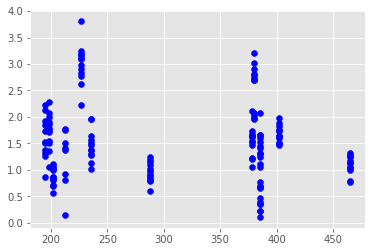

In [29]:
#crowne plaza SPOR plot
crowne_mask = comparision_df['Flag'] == 'Crowne Plaza'
crowne_df = comparision_df[crowne_mask]
print(crowne_df)
x = crowne_df['#Rooms']
y1 = crowne_df['SPOR']
# y2 = crowne_df['Room Subset']
plt.scatter(x, y1, color = 'b')
# plt.savefig('../images/crowne_SPOR.png')

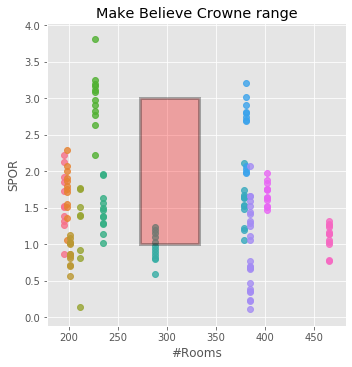

In [30]:

fig = sns.lmplot( x="#Rooms", y="SPOR", data=crowne_df, fit_reg=False, hue='#Rooms', legend=False)
fig.axes[0, 0].add_patch(patches.Rectangle((273, 1), 60, 2, alpha=0.3, facecolor='red', edgecolor='black', linewidth=3, linestyle='solid'))

# Move the legend to an empty part of the plot
# plt.legend(loc='lower right')
fig.set(title = 'Make Believe Crowne range')
# sns.plt.show()
fig.savefig('../images/make_believe.png')

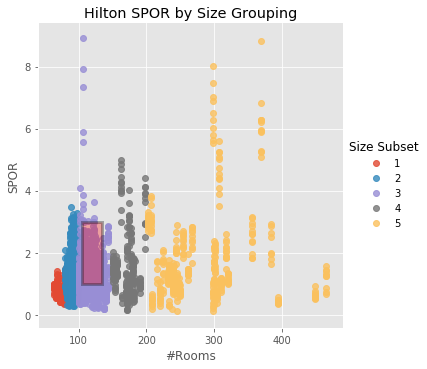

In [31]:
hilto_mask = comparision_df['Brand'] == 'Hilto'
hilto_df = comparision_df[hilto_mask]
x = hilto_df['#Rooms']
y = hilto_df['SPOR']
fig = sns.lmplot( x="#Rooms", y="SPOR", data=hilto_df, fit_reg=False, hue='Size Subset', legend=True)
fig.axes[0, 0].add_patch(patches.Rectangle((105, 1), 30, 2, alpha=0.3, facecolor='red', edgecolor='black', linewidth=3, linestyle='solid'))
fig.set(title = 'Hilton SPOR by Size Grouping')
plt.savefig('../images/hilto_by_size.png')

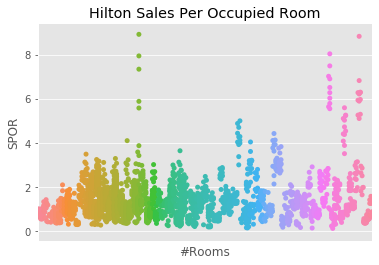

In [32]:
hilto_mask = comparision_df['Brand'] == 'Hilto'
hilto_df = comparision_df[hilto_mask]
fig = sns.swarmplot(x="#Rooms", y="SPOR", data=hilto_df)
fig.set(xticks=[])
fig.set(title = 'Hilton Sales Per Occupied Room')
plt.savefig('../images/hilton_spor.png')

In [37]:
hilto_mask1 = comparision_df['Brand'] == 'Hilto'
hilto_mask2 = comparision_df['Size Subset'] == 3
hilto_df = comparision_df[hilto_mask1 & hilto_mask2]
x = hilto_df['#Rooms']
y = hilto_df['SPOR']
fig = sns.lmplot( x="#Rooms", y="SPOR", data=hilto_df, fit_reg=False, hue='#Rooms', legend=False)
fig.axes[0, 0].add_patch(patches.Rectangle((105, 1), 30, 2, alpha=0.3, facecolor='red', edgecolor='black', linewidth=3, linestyle='solid'))
fig.set(title = 'Hilton Size Subset 3 with potential SPOR')
plt.savefig('../images/hilton_spor_sub3.png')

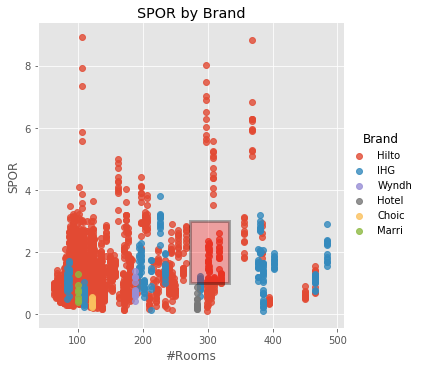

In [34]:
# x_all = comparision_df['#Rooms']
# y_all = comparision_df['SPOR']
fig = sns.lmplot(x="#Rooms", y="SPOR", data=comparision_df, fit_reg=False, hue='Brand', legend=True)
fig.axes[0, 0].add_patch(patches.Rectangle((273, 1), 60, 2, alpha=0.3, facecolor='red', edgecolor='black', linewidth=3, linestyle='solid'))
fig.set(title='SPOR by Brand')

plt.savefig('../images/all-brand-spor.png')

In [35]:
# hilton_mask = test_hotels['Brand'] == 'Hilto'
# hilton_df = test_hotels[hilton_mask].copy
# unique_hilton_flags = list(hilton_df